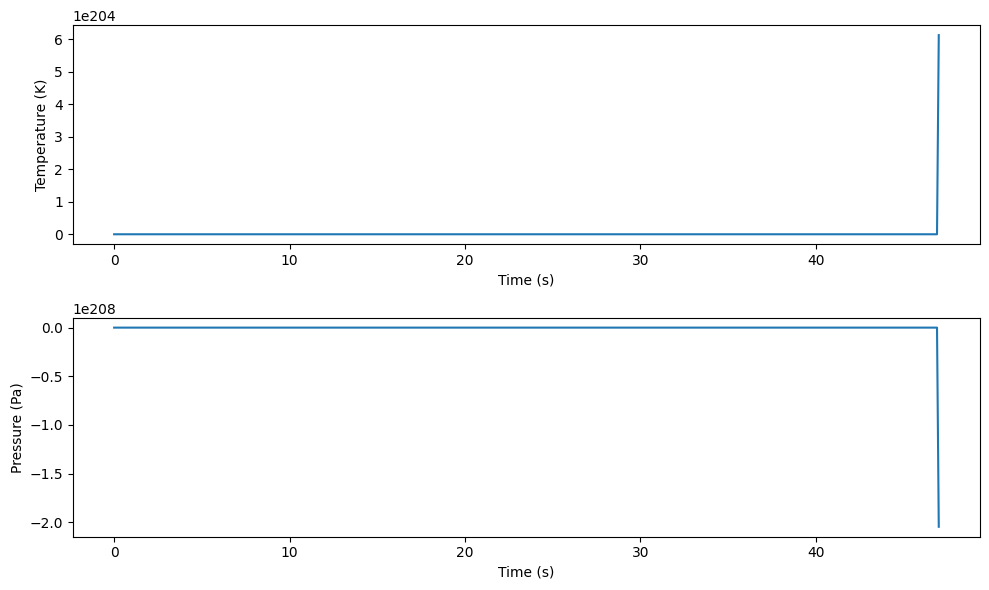

In [ ]:
# 1
import numpy as np
import matplotlib.pyplot as plt

# 储热罐参数
class ThermalStorage:
    def __init__(self, initial_mass, initial_temperature, initial_pressure, surface_area, volume):
        self.mass = initial_mass  # 初始质量
        self.temperature = initial_temperature  # 初始温度
        self.pressure = initial_pressure  # 初始压力
        self.surface_area = surface_area  # 表面积
        self.volume = volume  # 体积
        self.environment_temperature = 298  # 环境温度，单位：K

    # 质量守恒方程
    def mass_conservation(self, mass_in, mass_out, dt):
        self.mass += (mass_in - mass_out) * dt

    # 热量交换计算
    def heat_transfer(self, U_k):
        return -U_k * self.surface_area * (self.temperature - self.environment_temperature)

    # 能量守恒方程
    def energy_conservation(self, mass_in, mass_out, h_in, h_out, Q, cp, dt):
        dm = self.mass_conservation(mass_in, mass_out, dt)
        dT = (mass_in * h_in - mass_out * h_out + Q) / (self.mass * cp)
        self.temperature += dT

    # 理想气体状态方程的变形
    def ideal_gas_law(self, R):
        return self.pressure * self.volume / (self.mass * R)

    # 温度变化率计算
    def temperature_rate(self, mass_in, mass_out, T_in, T_out, Q, R, cp):
        term = (mass_in * cp * T_in + (1 - cp / R) * mass_out * T_out - Q) / (self.mass * cp)
        return term

    # 压力变化率计算
    def pressure_rate(self, mass_in, mass_out, T_in, T_out, Q, R, cp):
        term = (R * cp * (mass_in * T_in - mass_out * T_out) - Q * R) / (self.volume * cp)
        return term

    # 换热系数计算
    def heat_transfer_coefficient(self, U_0, alpha, P, P_amb, tau, mass_flow):
        return U_0 + alpha * (P - P_amb) + tau * abs(mass_flow)

# 压缩机参数和计算
class Compressor:
    def __init__(self, pressure_ratio, pressure_in, pressure_out, efficiency, gamma):
        self.pressure_ratio = pressure_ratio  # 压缩机压比
        self.pressure_in = pressure_in  # 进口压力
        self.pressure_out = pressure_out  # 出口压力
        self.efficiency = efficiency  # 等熵效率
        self.gamma = gamma  # 绝热指数

    # 等温条件下的出口温度计算
    def isothermal_exit_temperature(self, T_in):
        return T_in * (self.pressure_ratio ** ((self.gamma - 1) / self.gamma))

    # 实际压缩机出口温度计算
    def actual_exit_temperature(self, T_in):
        return (1 / self.efficiency) * T_in * ((self.pressure_ratio ** ((self.gamma - 1) / self.gamma)) + self.efficiency - 1)

    # 压缩机耗功计算
    def work(self, mass_flow, cp, T_in, T_out):
        return mass_flow * cp * (T_out - T_in)

    # 总耗功计算
    def total_work(self, compressors):
        total = 0
        for comp in compressors:
            total += comp.work
        return total

# 模拟过程
def simulate(time_steps, dt, storage, compressor):
    time = np.zeros(time_steps)
    temperature = np.zeros(time_steps)
    pressure = np.zeros(time_steps)

    for i in range(1, time_steps):
        # 计算换热系数
        U_k = storage.heat_transfer_coefficient(100, 0.1, storage.pressure, 101325, 0.01, 0.1)

        # 计算热量交换
        Q = storage.heat_transfer(U_k)

        # 计算压缩机出口温度
        T_comp_out = compressor.actual_exit_temperature(300)

        # 计算压缩机耗功
        W = compressor.work(0.1, 1005, 300, T_comp_out)

        # 更新储热罐状态
        storage.mass_conservation(0.1, 0.05, dt)
        storage.energy_conservation(0.1, 0.05, 1005 * 300, 1005 * T_comp_out, Q, 1005, dt)

        # 更新温度和压力
        dT = storage.temperature_rate(0.1, 0.05, 300, T_comp_out, Q, 287, 1005)
        dp = storage.pressure_rate(0.1, 0.05, 300, T_comp_out, Q, 287, 1005)
        storage.temperature += dT * dt
        storage.pressure += dp * dt

        # 记录数据
        time[i] = i * dt
        temperature[i] = storage.temperature
        pressure[i] = storage.pressure

    return time, temperature, pressure

# 参数初始化



storage = ThermalStorage(100, 300, 1e5, 10, 1)
compressor = Compressor(2, 1e5, 2e5, 0.85, 1.4)

# 运行模拟
time, temperature, pressure = simulate(1000, 0.1, storage, compressor)

# 绘制结果
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(time, temperature)
plt.xlabel('Time (s)')
plt.ylabel('Temperature (K)')

plt.subplot(2, 1, 2)
plt.plot(time, pressure)
plt.xlabel('Time (s)')
plt.ylabel('Pressure (Pa)')

plt.tight_layout()
plt.show()


In [3]:
# Thermal Energy Storage Analysis
import numpy as np

# Define input parameters
m = 10.0  # air mass inside the storage tank (kg)
m_dot_in = 2.0  # air mass flow rate into the storage tank (kg/s)
m_dot_out = 1.0  # air mass flow rate out of the storage tank (kg/s)
U_k = 10.0  # heat transfer coefficient (W/m²·K)
A = 5.0  # surface area of the storage tank (m²)
T = 300.0  # temperature inside the storage tank (K)
T_env = 290.0  # ambient temperature (K)
c_p = 1005.0  # specific heat capacity at constant pressure (J/kg·K)
c_v = 717.0  # specific heat capacity at constant volume (J/kg·K)
R = 287.0  # specific gas constant for air (J/kg·K)
V = 1.0  # volume of the storage tank (m³)

# Calculate heat exchange with the environment (Equation 8)
Q_dot = -U_k * A * (T - T_env)

# Calculate temperature change rate (Equation 11)
dTdt = (1 / m) * (m_dot_in * (c_p / c_v) * T + 
                 (1 - (c_p / c_v)) * m_dot_out * T) - \
       (Q_dot * R) / (V * m * c_v)

# Calculate pressure change rate (Equation 12dp)
dt = (R * c_p / (V * c_v)) * (m_dot_in * T - m_dot_out * T) - \
       (Q_dot * R) / (V * c_v)

# Print results
print(f"Temperature change rate (dT/dt): {dTdt:.2f} K/s")
print(f"Pressure change rate (dp/dt): {dpdt:.2f} Pa/s")



Temperature change rate (dT/dt): 92.06 K/s


NameError: name 'dpdt' is not defined

In [ ]:
# Parameters for heat transfer coefficient calculation (Equation 13)
U_0 = 10.0  # heat transfer coefficient when p = p_env and mass flow rate is zero (W/m²·K)
alpha = 0.1  # coefficient reflecting pressure effect on convection (W/m²·K·Pa)
P = 101325.0  # pressure inside the tank (Pa)
P_env = 101325.0  # ambient pressure (Pa)
tau = 0.01  # coefficient reflecting mass flow rate effect on convection (W/m²·K·(kg/s))

# Calculate heat transfer coefficient (Equation 13)
U_k = U_0 + alpha * (P - P_env) + tau * abs(m_dot_in - m_dot_out)

# Update heat transfer coefficient if needed
print(f"Heat transfer coefficient (U_k): {U_k:.2f} W/m²·K")





Heat transfer coefficient (U_k): 10.01 W/m²·K


In [8]:
!pip3 install pandas

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 11.3 MB 1.8 MB/s eta 0:00:01
     |████████████████████████████████| 347 kB 42.0 MB/s eta 0:00:01
     |████████████████████████████████| 509 kB 48.2 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
import numpy as np
from scipy.integrate import solve_ivp

# 定义参数
U0 = 10.0  
alpha = 0.1  
P_env = 101325.0  
tau = 0.01  

A = 50
V = 100  
c_p = 1005.0  
c_v = 717.0  
R = 287.0  

# p range 2e5-50e5

T_env = 290.0  # ambient temperature (K)
c_p = 1005.0  # specific heat capacity at constant pressure (J/kg·K)
c_v = 717.0  # specific heat capacity at constant volume (J/kg·K)
R = 287.0  # specific gas constant for air (J/kg·K)
V = 1.0  # volume of the storage tank (m³)

m_dot_in =1692
m_dot_out = 484.6 

# 微分方程
def dT_dt(T, p, m):
    U_k = U0 + alpha * (p - P_env) + tau * abs(m_dot_in - m_dot_out)
    Q = U_k * A * (T - T_env)
    dTdt = (1 / m) * (m_dot_in * (c_p / c_v) * T_initial + (1 - (c_p / c_v)) * m_dot_out * T) - (Q * R) / (V * m * c_v)
    return dTdt


def dp_dt(T, p, m):
    U_k = U0 + alpha * (p - P_env) + tau * abs(m_dot_in - m_dot_out)
    Q = -U_k * A * (T - T_env)
    dpdt = (R * c_p / (V * c_v)) * (m_dot_in * T_initial - m_dot_out * T) - (Q * R) / (V * c_v)
    return dpdt

# 初始条件
T_initial = 300.0  
p_initial = 101325.0  
m_initial = 10.0  


# 时间范围
t_span = (0, 10)  
t_eval = np.linspace(t_span[0], t_span[1], 1)

# 解微分方程
def model(t, y):
    T, p, m = y
    dT = dT_dt(T, p, m)
    dp = dp_dt(T, p, m)
    dm = (m_dot_in - m_dot_out)  # 由质量守恒方程得出
    return [dT, dp, dm]

# 初始状态向量 [温度, 压力, 质量]
y0 = [T_initial, p_initial, m_initial]

# 使用solve_ivp求解微分方程
solution = solve_ivp(model, t_span, y0, t_eval=t_eval, method='RK45')

# 打印结果
import pandas as pd

df = pd.DataFrame({
    'Time': solution.t,
    'Temperature (K)': solution.y[0],
    'Pressure (Pa)': solution.y[1],
    'Mass (kg)': solution.y[2]
})

print(df)



KeyboardInterrupt: 

In [21]:
# 压缩机参数
T_comp_in = 25+273.15  # 进气温度，单位：K
beta_comp = 3.5  # 压缩比
eta_comp = 0.744  # 等熵效率
p_comp_in = 0.1*1e6  # 进气压力，单位：Pa
m_dot_comp = 1692  # 质量流量，单位：kg/h
cp = 1005  # 空气的比热容，单位：J/(kg·K)
N = 1  # 压缩机数量
k = 1.4  # 绝热指数


# 计算等熵条件下的出口温度

T_equals = T_comp_in * (beta_comp ** ((k - 1)/k))

# 计算实际出口温度
T_real_out = (1 / eta_comp) * T_comp_in * ((beta_comp ** ((k - 1)/k)) + eta_comp - 1)

# 计算出口压力
p_comp_out = p_comp_in * beta_comp

# 计算单台压缩机的功耗
W_comp_i = m_dot_comp * cp * (T_real_out - T_comp_in)

# 计算总功耗
W_comp = N * W_comp_i

# 输出结果
print(f"等效出口温度: {T_equals-273.1:.2f} K")
print(f"实际出口温度: {T_real_out-273.1:.2f} K")
print(f"出口压力: {p_comp_out:.2f} Pa")
print(f"单台压缩机功耗: {W_comp_i:.2f} W")
print(f"总压缩机功耗: {W_comp:.2f} W")

(77.5-74.7)/77.47

等效出口温度: 153.36 K
实际出口温度: 197.52 K
出口压力: 350000.00 Pa
单台压缩机功耗: 293270935.99 W
总压缩机功耗: 293270935.99 W


0.036143023105718305